In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

#basins=load_basins_data()
basins=geopandas.read_file("../datasets/basins/basins_with_climate_zones.shp")
basins.set_index("NAME",inplace=True)
basins.drop(['CONTINENT', 'OCEAN', 'CLIMATE_AR','COLOR_HEX'],axis=1,inplace=True)
basins.columns=['RASTAREA','MAIN_CLIMATE','geometry']

In [3]:
Nbasins=basins.shape[0]
Ndatasets=1694
data_TWS='GRACE_JPL_mascons'
min_year=2003
max_year=2014

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [5]:
def get_Afilter(data_P,data_ET,data_R,data_TWS,basin_id):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
    R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
    
    time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]

    P_filter=P_month.loc[basin_id,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
    ET_filter=ET_month.loc[basin_id,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
    R_filter=R_month.loc[basin_id,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
    TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

    P_filter.index=time_idx
    ET_filter.index=time_idx
    R_filter.index=time_idx
    TWSC_filter.index=time_idx
    
    fillingP=(np.sum(np.isnan(P_filter))==0)
    fillingET=(np.sum(np.isnan(ET_filter))==0)
    fillingR=(np.sum(np.isnan(R_filter))==0)
    fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

    if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
        A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    else:
        print('This basin is not entirely covered')
    return P_filter,ET_filter,R_filter,TWSC_filter,A_filter

In [6]:
def get_TWSC_uncertainty(data_TWS,basin_id):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    dTWS_month=pd.read_csv('../results/hydrology/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]
    
    TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
    TWSC_filter.index=time_idx
    
    dTWSC_filter=dTWS_month.loc[basin_id,['TWS_uncertainty_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
    dTWSC_filter.index=time_idx

    return TWSC_filter,dTWSC_filter

# 1. Plot TWS reconstruction for the best combination

In [7]:
NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
RMSE_tab=pd.read_csv("../results/water_budget/RMSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
deseason_corr_tab=pd.read_csv("../results/water_budget/deseason_correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
perc_months_tab=pd.read_csv("../results/water_budget/GRACE_uncertainty_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

max_NSEc=pd.Series(np.nanmax(NSEc_tab,axis=1),index=NSEc_tab.index,name='max NSEc').to_frame()
max_NSEc['area']=basins['geometry'].to_crs('epsg:6933').area/1e6
max_NSEc['nb positive comb']=np.sum(NSEc_tab>=0,axis=1)
max_NSEc.sort_values(by='max NSEc',ascending=False)

,max NSEc,area,nb positive comb
PARANA,0.709236,2.639954e+06,455
BRAZOS,0.657111,1.185678e+05,592
JAGUARIBE,0.650368,7.317369e+04,768
DANUBE,0.628426,7.973351e+05,513
SAO FRANCISCO,0.627346,6.348415e+05,839
...,...,...,...
LAKE GAIRDNER,-1.137183,1.129553e+05,0
HAYES,-1.204932,1.080354e+05,0
RHARSA,-1.223324,1.143265e+05,0
AMAZON,-1.282651,5.941000e+06,0


<IPython.core.display.Javascript object>


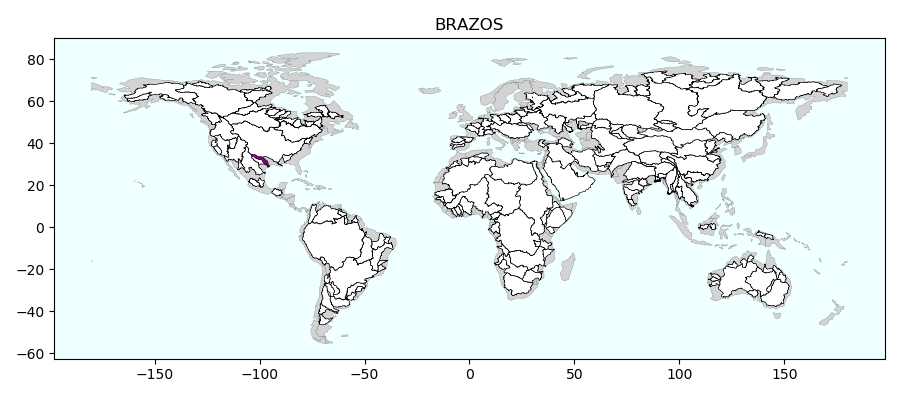

In [8]:
basin_name='BRAZOS'

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.4)
basins.loc[[basin_name],'geometry'].plot(ax=ax, color='purple')
plt.title(basin_name)
ax.set_facecolor('azure')
plt.tight_layout()
plt.show()

Number of combinations with non-missing values

In [9]:
np.sum(~np.isnan(NSEc_tab.loc[basin_name]))

1694

Choose the best combination

In [10]:
comb1=NSEc_tab.loc[basin_name].sort_values(ascending=False).index[0]
data_P,data_ET,data_R=decompose_dataset(comb1)[:3]

P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS,basin_name)
if data_TWS=='GRACE_JPL_mascons':
    TWSC_filter,dTWSC_filter=get_TWSC_uncertainty(data_TWS,basin_name)
    within_bounds=100*np.sum((A_filter<=TWSC_filter+dTWSC_filter)&(A_filter>=TWSC_filter-dTWSC_filter))/A_filter.shape[0]

Impose a specific combination

In [30]:
data_P='ERA5_Land'
data_ET='GLDAS22_CLSM25'
data_R='GLDAS22_CLSM25'
P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS,basin_name)
TWSC_filter,dTWSC_filter=get_TWSC_uncertainty(data_TWS,basin_name)
within_bounds=100*np.sum((A_filter<=TWSC_filter+dTWSC_filter)&(A_filter>=TWSC_filter-dTWSC_filter))/A_filter.shape[0]

Mean monthly values to interpret the cyclic NSE.

In [11]:
df=TWSC_filter.to_frame()
df['month']=TWSC_filter.index.month
df_month=df.groupby('month').mean()
df_month.columns=['mean month']
seasonal_TWSC=df.join(df_month,on='month')

<IPython.core.display.Javascript object>


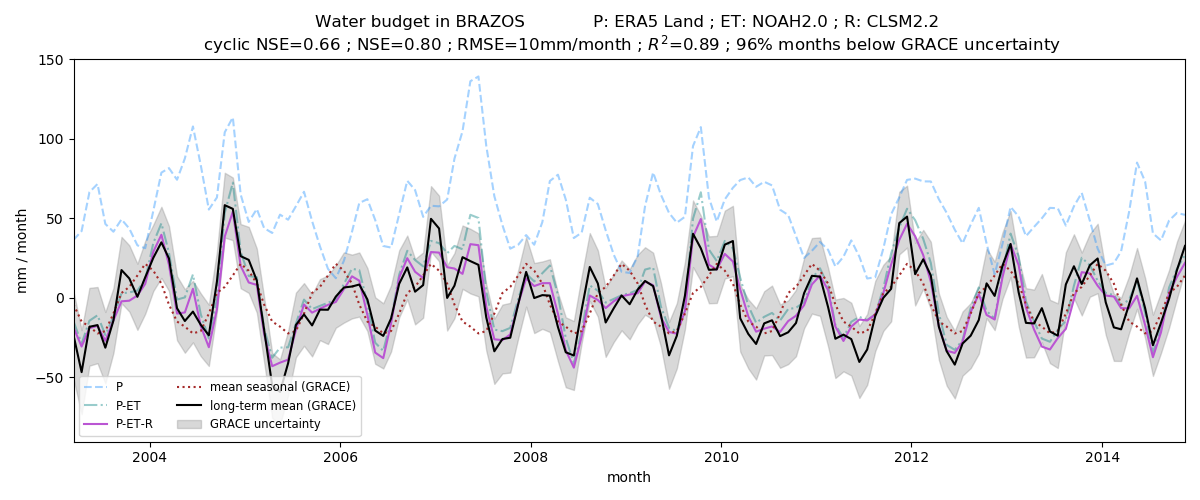

In [12]:
plt.figure(figsize=(12,5))
plt.plot(P_filter,'--',alpha=0.4,color='dodgerblue',label='P')
plt.plot(P_filter-ET_filter,'-.',alpha=0.4,color='teal',label='P-ET')
plt.plot(A_filter,color='mediumorchid',label='P-ET-R')
if data_TWS=='GRACE_JPL_mascons':
    plt.fill_between(TWSC_filter.index,TWSC_filter-dTWSC_filter,TWSC_filter+dTWSC_filter,
                 color='grey',alpha=0.3,label='GRACE uncertainty')
plt.plot(seasonal_TWSC['mean month'],':',color='brown',label='mean seasonal (GRACE)')
plt.plot(TWSC_filter,'k',label='long-term mean (GRACE)')

plt.xlim([TWSC_filter.index[0],TWSC_filter.index[-1]])
plt.xlabel('month')
plt.ylabel('mm / month')
plt.legend(fontsize='small',ncol=2,loc='lower left')

if data_TWS=='GRACE_JPL_mascons':
    plt.title('Water budget in {}             P: {} ; ET: {} ; R: {} \n cyclic NSE={:.2f} ; NSE={:.2f} ; RMSE={:.0f}mm/month ; $R^2$={:.2f} ; {:.0f}% months below GRACE uncertainty'.format(basin_name,
            dict_dataset_name[data_P],dict_dataset_name[data_ET],
            dict_dataset_name[data_R],
            np.round(compute_cyclic_NSE(A_filter,TWSC_filter),2),
            np.round(compute_NSE(A_filter,TWSC_filter),2),
            np.round(compute_RMSE(A_filter,TWSC_filter),0),
            np.round(A_filter.corr(TWSC_filter),2),
            np.round(within_bounds,0)))
else:
    plt.title('Water budget in {}             P: {} ; ET: {} ; R: {} \n cyclic NSE={:.2f} ; NSE={:.2f} ; RMSE={:.0f}mm/month ; $R^2$={:.2f}'.format(basin_name,
            dict_dataset_name[data_P],dict_dataset_name[data_ET],
            dict_dataset_name[data_R],
            np.round(compute_cyclic_NSE(A_filter,TWSC_filter),2),
            np.round(compute_NSE(A_filter,TWSC_filter),2),
            np.round(compute_RMSE(A_filter,TWSC_filter),0),
            np.round(A_filter.corr(TWSC_filter),2)))
plt.tight_layout()
plt.show()

Alternative representation of the water budget with P as a reference.

<IPython.core.display.Javascript object>


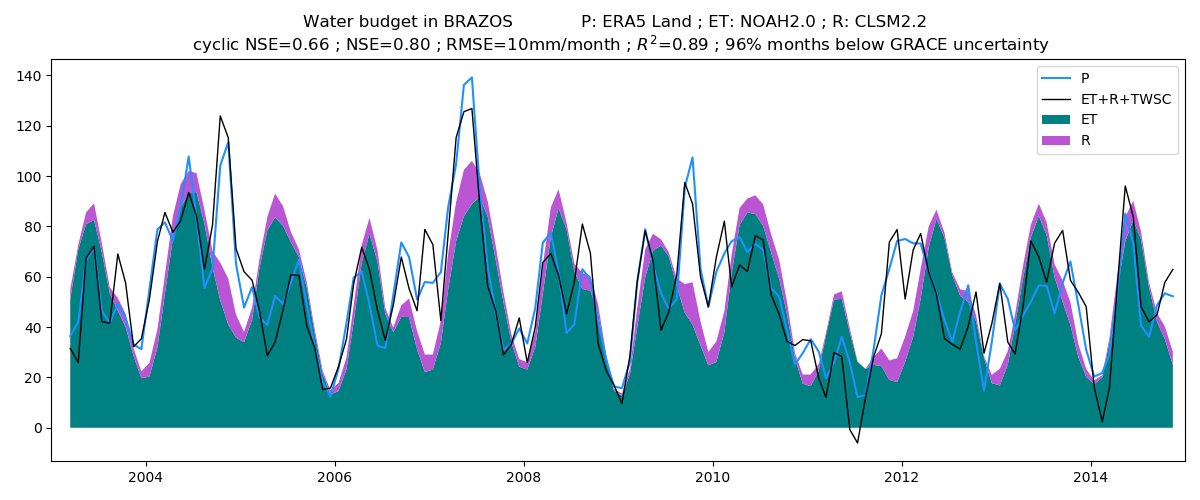

In [13]:
plt.figure(figsize=(12,5))
plt.plot(TWSC_filter.index,P_filter,color='dodgerblue',label='P')
plt.stackplot(TWSC_filter.index,ET_filter,R_filter,colors=['teal','mediumorchid'],labels=['ET','R'])
#plt.stackplot(TWSC_filter.index,ET_filter,R_filter,TWSC_filter,colors=['teal','mediumorchid','grey'])
plt.plot(TWSC_filter.index,ET_filter+R_filter+TWSC_filter,'k',linewidth=1,label='ET+R+TWSC')
plt.xlim([pd.Timestamp('2002-12-31'),pd.Timestamp('2015-01-01')])
plt.legend()
plt.title('Water budget in {}             P: {} ; ET: {} ; R: {} \n cyclic NSE={:.2f} ; NSE={:.2f} ; RMSE={:.0f}mm/month ; $R^2$={:.2f} ; {:.0f}% months below GRACE uncertainty'.format(basin_name,
            dict_dataset_name[data_P],dict_dataset_name[data_ET],
            dict_dataset_name[data_R],
            np.round(compute_cyclic_NSE(A_filter,TWSC_filter),2),
            np.round(compute_NSE(A_filter,TWSC_filter),2),
            np.round(compute_RMSE(A_filter,TWSC_filter),0),
            np.round(A_filter.corr(TWSC_filter),2),
            np.round(within_bounds,0)))
plt.tight_layout()
plt.show()

## What is the difference between 2 combinations?

In [14]:
N1=0.1
N2=0.5
i2=np.argmin(NSEc_tab.loc[basin_name].sort_values(ascending=True)<N2)
comb2=NSEc_tab.loc[basin_name].sort_values(ascending=True).index[i2]
if i2==0:
    print('N2 too high')
i1=np.argmin(NSEc_tab.loc[basin_name].sort_values(ascending=True)<N1)
comb1=NSEc_tab.loc[basin_name].sort_values(ascending=True).index[i1]
if i1==0:
    print('N1 too high')

In [15]:
print(NSE_tab.loc[basin_name,comb1],NSEc_tab.loc[basin_name,comb1],RMSE_tab.loc[basin_name,comb1])
print(NSE_tab.loc[basin_name,comb2],NSEc_tab.loc[basin_name,comb2],RMSE_tab.loc[basin_name,comb2])

0.4694442680961343 0.10003502714198632 16.820440135008987
0.7067463144550923 0.5025630121742684 12.505284878944845


<IPython.core.display.Javascript object>


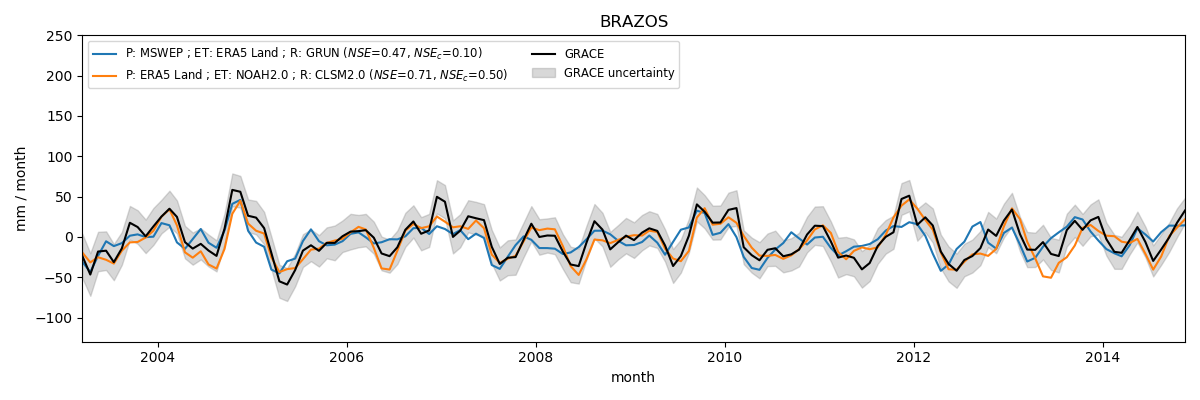

In [17]:
list_comb=[comb1,comb2]

if data_TWS=='GRACE_JPL_mascons':
    TWSC_filter,dTWSC_filter=get_TWSC_uncertainty(data_TWS,basin_name)

plt.figure(figsize=(12,4))

for comb in list_comb:
    data_P,data_ET,data_R=decompose_dataset(comb)[:3]
    P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS,basin_name)
    plt.plot(A_filter,label='{} ($NSE$={:.2f}, $NSE_c$={:.2f})'.format(format_combination(comb),
                                                      NSE_tab.loc[basin_name,comb],NSEc_tab.loc[basin_name,comb]))

plt.plot(TWSC_filter,'k',label='GRACE')
plt.fill_between(TWSC_filter.index,TWSC_filter-dTWSC_filter,TWSC_filter+dTWSC_filter,
                 color='grey',alpha=0.3,label='GRACE uncertainty')


plt.xlim([TWSC_filter.index[0],TWSC_filter.index[-1]])
plt.ylim([-130,250])
plt.xlabel('month')
plt.ylabel('mm / month')
plt.legend(fontsize='small',ncol=2,loc='upper left')
#plt.title('{} (maximum $NSE$={:.2f}, maximum $NSE_c$={:.2f})'.format(basin_name,np.nanmax(NSE_tab.loc[basin_name]),
#                                                                  np.nanmax(NSEc_tab.loc[basin_name])))
plt.title(basin_name)
plt.tight_layout()
plt.show()

# 2. Other metrics than NSE

## 2.1. Correlation between non-seasonal components

Seasonal decomposition obtained with unweighted least squares. Removed from the time series to keep only the non-seasonal part. Problem: the correlation only does not inform us on the magnitude of the difference (RMSE).

<IPython.core.display.Javascript object>


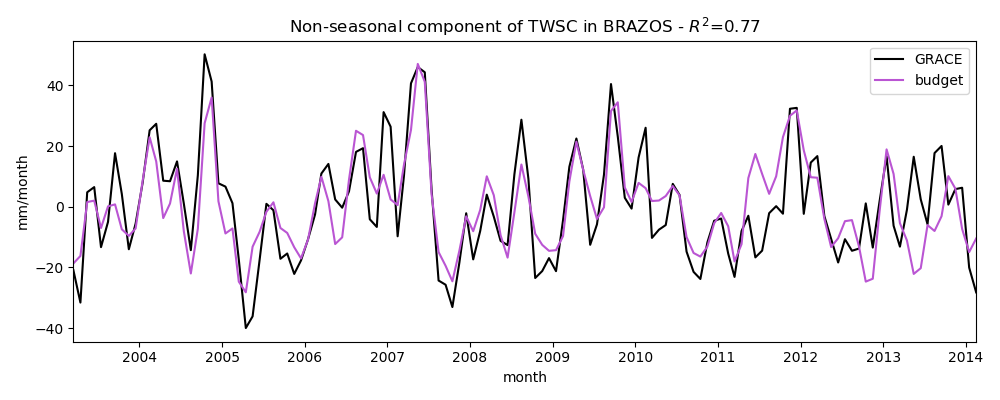

In [18]:
deseason_TWSC=deseasone(TWSC_filter)
deseason_A=deseasone(A_filter)

plt.figure(figsize=(10,4))
plt.plot(deseason_TWSC,'k',label='GRACE')
plt.plot(deseason_A,'mediumorchid',label='budget')
plt.xlim([deseason_TWSC.index[0],deseason_TWSC.index[-1]])
plt.legend()
plt.xlabel('month')
plt.ylabel('mm/month')
plt.title('Non-seasonal component of TWSC in {} - $R^2$={:.2f}'.format(basin_name,deseason_TWSC.corr(deseason_A)))
plt.tight_layout()
plt.show()

## 2.2. Correlation between montly values

Can show consistent tendency to underestimate extreme values for example

In [19]:
#import numpy as np
from sklearn.linear_model import LinearRegression

X=TWSC_filter.values.reshape(-1,1)
Y=A_filter.values
model = LinearRegression().fit(X,Y)
r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)

b=model.intercept_
a=model.coef_[0]

coefficient of determination: 0.7449867749105434


<IPython.core.display.Javascript object>


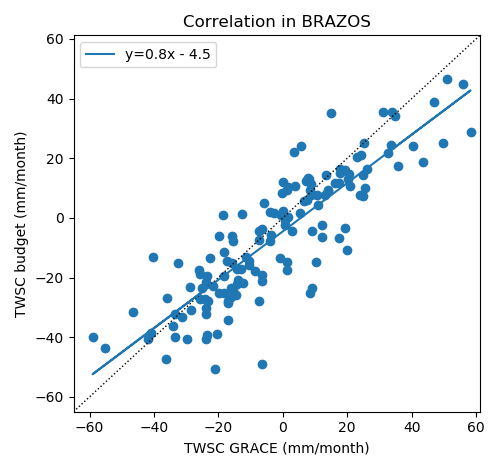

In [20]:
plt.figure(figsize=(5,4.7))
plt.plot([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()],[1.1*TWSC_filter.min(),1.05*TWSC_filter.max()],'k:',linewidth=1)
plt.plot(X,a*X+b,label='y={:.1f}x {} {:.1f}'.format(np.round(a,1),np.where(b>0,'+','-'),np.abs(np.round(b,1))))
plt.scatter(TWSC_filter,A_filter)
plt.xlim([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()])
plt.ylim([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()])
plt.legend()
plt.xlabel('TWSC GRACE (mm/month)')
plt.ylabel('TWSC budget (mm/month)')
plt.title('Correlation in {}'.format(basin_name))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


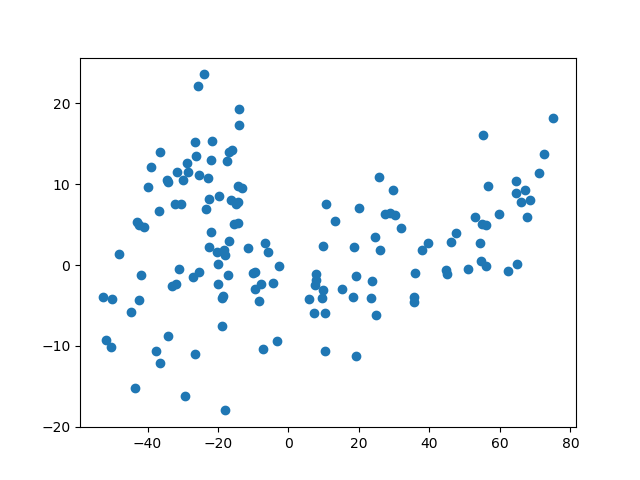

In [53]:
plt.figure()
plt.scatter(TWSC_filter,TWSC_filter-A_filter)
plt.show()